# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 24.11.2021

Мягкий дедлайн: 23:59MSK 07.12.2021


Жесткий дедлайн: 23:59MSK 10.12.2021

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from matplotlib import cm
from sklearn.ensemble import GradientBoostingRegressor


In [2]:
from sklearn.datasets import load_boston

In [4]:
boston = load_boston()

In [5]:
X = boston["data"]
y = boston["target"]

In [6]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [7]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.458762239265575

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [112]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    predict = np.full((X.shape[0], num_runs), np.nan)
    for i in range(num_runs):
        bs_index = np.random.randint(low = 0, high = X.shape[0], size = X.shape[0])
        oob = np.setdiff1d(np.arange(X.shape[0]), bs_index)
        regressor.fit(X[bs_index], y[bs_index])
        y_pred = regressor.predict(X[oob])
        predict[oob, i] = y_pred
    not_in_oob = (~np.isnan(predict)).sum(axis=1) 
    nio = []
    for i in not_in_oob:
        if i != 0:
            nio.append(True)
        else:
            nio.append(False)
    aver_pred = np.nanmean(predict[nio], axis=1) 
    biase = np.mean((aver_pred - y[nio]) ** 2)
    variance = np.mean(np.nanvar(predict[nio], axis=1))
    error = np.nanmean((predict.T - y[nio]) ** 2)
    return biase, variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [113]:
biase, variance, error = compute_biase_variance(LinearRegression(), X, y)
print('LinearRegression: смещение -', biase, ', разброс -', variance, ', ошибка -', error)

LinearRegression: смещение - 23.70428782060845 , разброс - 0.9268790862311466 , ошибка - 24.735963838739824


In [12]:
biase, variance, error = compute_biase_variance(DecisionTreeRegressor(), X, y)
print('DecisionTreeRegressor: смещение -', biase, ', разброс -', variance, ', ошибка -', error)

DecisionTreeRegressor: смещение - 10.204094371800815 , разброс - 12.922152117309144 , ошибка - 23.005095838397743


In [11]:
# каким-то чудом загрузилось, лучше не перезапускать
biase, variance, error = compute_biase_variance(RandomForestRegressor(), X, y)
print('RandomForestRegressor: смещение', biase, 'разброс', variance, 'ошибка', error)

RandomForestRegressor: смещение 10.600730268456324 разброс 2.206680337610428 ошибка 12.795247226229492


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ да, согласуется. 
1. Нам известно, что ошибка должна примерно равняться сумме сещения и разброса, что действительно видно на результатах выше
2. В случайном лесу недостатки дерева уходят, из-за чего смещение там намного ниже, чем в решающем дереве
3. Линейная регрессия должна иметь большое смещение и маленький разброс, что подтвердилось

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__ в теории бэггинг уменьшает разброс алгоритма в n_estimators (= # бутстреп алгоритмов, обученных на выборках. P. s. его видно, когда я работаю со случайным лесом) раз. Так как выборки строятся с помощью бутсрепа, выходит большая корреляция, поэтому не так уж идеально и выполняется.

In [13]:
biase, variance, error = compute_biase_variance(BaggingRegressor(LinearRegression()), X, y)
print('LinearRegression: смещение -', biase, ', разброс -', variance, ', ошибка -', error)

LinearRegression: смещение - 23.73648004711579 , разброс - 1.0337396352938009 , ошибка - 24.777541863534577


In [15]:
biase, variance, error = compute_biase_variance(BaggingRegressor(DecisionTreeRegressor()), X, y)
print('DecisionTreeRegressor: смещение -', biase, ', разброс -', variance, ', ошибка -', error)

DecisionTreeRegressor: смещение - 10.640711429970057 , разброс - 3.36826081337965 , ошибка - 13.946648945882732


In [ ]:
# нифига не грузит
biase, variance, error = compute_biase_variance(BaggingRegressor(RandomForestRegressor()), X, y)
print('RandomForestRegressor: смещение', biase, 'разброс', variance, 'ошибка', error)

In [10]:
# попробуем задействовать все ядра с помощью n_jobs = -1 для RandomForestRegressor (грузилось минут 25)
reggressor = BaggingRegressor(base_estimator = RandomForestRegressor(), 
                              n_estimators = 10, random_state = 44, n_jobs = -1)
biase, variance, error = compute_biase_variance(reggressor, X, y)
print('RandomForestRegressor: смещение -', biase, ', разброс -', variance, ', ошибка -', error) 

RandomForestRegressor: смещение - 11.602069455754615 , разброс - 1.4113887168502623 , ошибка - 13.050891253863732


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [106]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test_objects/X.shape[0])
    for i in range(num_runs):
        bs_index = np.random.randint(low=0, high=X_train.shape[0], size=X_train.shape[0])
        regressor.fit(X_train[bs_index], y_train[bs_index])
        y_pred = regressor.predict(X_test)
        plt.scatter(np.arange(X_test.shape[0]), y_pred, 
                    color=cm.get_cmap("Paired")(np.linspace(0, 1, X_test.shape[0]))) # для цветов
    plt.scatter(np.arange(y_test.shape[0]), y_test, color='black', marker='*')
    plt.title(title)
    plt.xlabel('Номер')
    plt.ylabel('Значение')

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

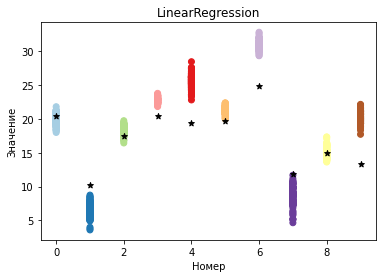

In [107]:
plot_predictions(LinearRegression(), X, y, title='LinearRegression')

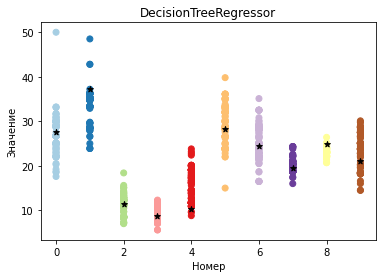

In [108]:
plot_predictions(DecisionTreeRegressor(), X, y, title='DecisionTreeRegressor')

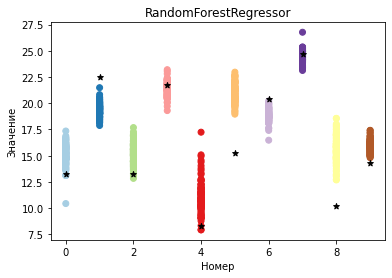

In [109]:
plot_predictions(RandomForestRegressor(), X, y, title='RandomForestRegressor')

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__
1. LinearRegression. При низком разбросе ответы становятся кучнее. При усреднении смещение будет высоким, так как ответ будет находиться далеко от истинного.
2. DecisionTreeRegressor. Так как у рещающего дерева высокие шансы переобучиться, то можно заметить откуда такой высокий разброс.При усреднении смещение будет ниже, чем у LinearRegression.
3. RandomForestRegressor. Случайный лес избавляется от разброса дерева, поэтому ответы начинают приближаться друг к другу, собираясь в так называемую кучку, в следствии чего различия ответов разных моделий уменшились. Смещение возникает, потому что есть случаю при которых лус "промахивается". При усреднении не далеко уходим от истинного результата.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [116]:
max_depth = 10
max_features= X.shape[1]
biases = np.arange(max_depth + max_features)
variances = np.arange(max_depth + max_features)
errors = np.arange(max_depth + max_features)
for i in range(max_depth):
    regressor = DecisionTreeRegressor(max_depth = i + 1)
    biases[i], variances[i], errors[i] = compute_biase_variance(regressor, X, y)
for i in range(max_features):
    regressor = DecisionTreeRegressor(max_features = i + 1)
    biases[i + max_depth], variances[i + max_depth], errors[i + max_depth] = compute_biase_variance(regressor, X, y)

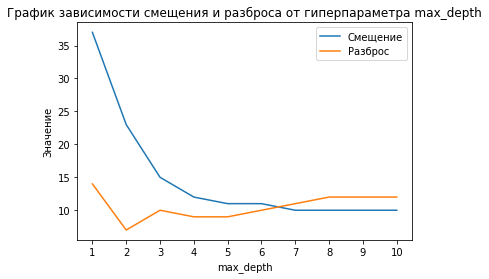

In [130]:
plt.title('График зависимости смещения и разброса от гиперпараметра max_depth')
plt.plot(np.arange(max_depth) + 1, biases[:max_depth])
plt.plot(np.arange(max_depth) + 1, variances[:max_depth])
plt.xlabel('max_depth')
plt.ylabel('Значение')
plt.xticks(np.arange(max_depth) + 1)
plt.legend(['Смещение', 'Разброс'])
plt.show()

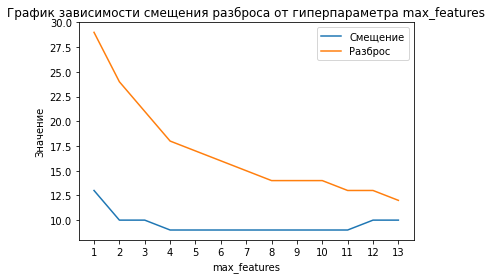

In [131]:
plt.title('График зависимости смещения разброса от гиперпараметра max_features')
plt.plot(np.arange(max_features) + 1, biases[max_depth:])
plt.plot(np.arange(max_features) + 1, variances[max_depth:])
plt.xlabel('max_features')
plt.ylabel('Значение')
plt.xticks(np.arange(max_features) + 1)
plt.legend(['Смещение', 'Разброс'])
plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__
1. Чем больше max_depth, тем ниже смещение. Это значит, что наше дерево начинает лучше предсказывать при большем max_depth. Значит предсказываем в среднем тоже лучше, но начинается переобучение, и растет разброс.Стараемся сильнее подстраиться под выборку, поэтому разброс увеличивается не значительно. 
2. Аналогично пункту 1 (только для max_features)

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

<img src="https://media1.tenor.com/images/9b8fbe9214504bcf6c60fe4e4f7e114e/tenor.gif?itemid=5416416" style="width: 400px">